In [48]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *
from intercluster import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

cmap2 = ["white", cmap(5)]
cmap2 = ListedColormap(cmap2)

subset_colors = [cmap(5), cmap(6), cmap(7), cmap(1), cmap(3), cmap(0)]
cmap3 = ListedColormap(subset_colors)

### Data

In [4]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/home/kevinq/interpretable/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [5]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [6]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [7]:
unscaled_data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = MinMaxScaler()
data = scaler.fit_transform(unscaled_data)

### Running Experiments

In [65]:
# REMINDER: The seed should only be given to the experiment object which 
# initializes the seed at the beginning of the experiment. It should NOT 
# within the parameters of any sub-function or class, since these will 
# reset the seed each time they are given one. 
np.random.seed(919817)

In [66]:
k = 7

In [46]:
# Parameters:
k = 7
n_clusters = k
min_rules = k
n_trees = 100

# Base module
base = KMeansBase(n_clusters)
A,C = base.assign(data)
y = base.clustering.labels_

# Modules:
mod1 = ExkmcMod(
    n_clusters = n_clusters,
    kmeans_model = base.clustering,
    base_tree = 'IMM',
    min_rules = min_rules
)

# Forest:
forest_tree_params = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 2
}

forest_params1 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_objective1 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 0.9
)

prune_params1 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective1,
    'lambda_search_range' : np.linspace(0,2,101)
}

mod2 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params1,
    clustering = base,
    prune_params = prune_params1,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest'
)

prune_objective2 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 1
)

prune_params2 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective2,
    'lambda_search_range' : np.linspace(0,2,101)
}

mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params1,
    clustering = base,
    prune_params = prune_params2,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Full-Cover'
)

'''
forest_tree_params2 = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 1
}

forest_params2 = {
    'tree_model' : SVMTree,
    'tree_params' : forest_tree_params2,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_params2 = {
    'search_range' : np.linspace(0,1,100),
    'coverage_threshold' : 0.5 * len(data)
}

mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params2,
    clustering = base,
    prune_params = prune_params2,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'SVM-Forest'
)
'''

baseline_list = [base]
module_list = [mod1, mod2, mod3]

In [9]:
# Computing statistics:
#df = Ex1_results
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [43]:
table_df = mean_df.iloc[0,:].to_frame()
table_df

0
coverage                      ExKMC                    1.000000
                              ExKMC-Forest             0.925811
                              Forest                   0.915968
                              Forest-Depth-5           0.912328
                              Forest-Full-Cover        0.946515
                              KMeans                   1.000000
                              SVM-Forest               0.758221
                              SVM-Forest-Full-Cover    1.000000
depth                         ExKMC                    6.000000
                              ExKMC-Forest             6.000000
                              Forest                   2.000000
                              Forest-Depth-5           5.000000
                              Forest-Full-Cover        2.000000
                              SVM-Forest               1.000000
                              SVM-Forest-Full-Cover    1.000000
normalized-clustering-cost    ExKMC                    0.283833
                              ExKMC-Forest             0.321458
                              Forest                   0.275690
                              Forest-Depth-5           0.256778
                              Forest-Full-Cover        0.420051
                              KMeans                   0.260371
                              SVM-Forest               0.282891
                              SVM-Forest-Full-Cover    0.694500
overlap                       ExKMC                    1.000000
                              ExKMC-Forest             1.230865
                              Forest                   1.095670
                              Forest-Depth-5           1.061936
                              Forest-Full-Cover        1.684634
                              KMeans                   1.000000
                              SVM-Forest               1.083202
                              SVM-Forest-Full-Cover    1.040910
overlap-distance              ExKMC                         NaN
                              ExKMC-Forest             1.207486
                              Forest                   0.852202
                              Forest-Depth-5           1.142882
                              Forest-Full-Cover        1.030075
                              KMeans                        NaN
                              SVM-Forest               1.435313
                              SVM-Forest-Full-Cover    0.726879
point-average-clustering-cost ExKMC                   97.638466
                              ExKMC-Forest           102.427209
                              Forest                  86.886950
                              Forest-Depth-5          80.609223
                              Forest-Full-Cover      140.272732
                              KMeans                  89.567539
                              SVM-Forest              73.939435
                              SVM-Forest-Full-Cover  238.908055

### Plotting

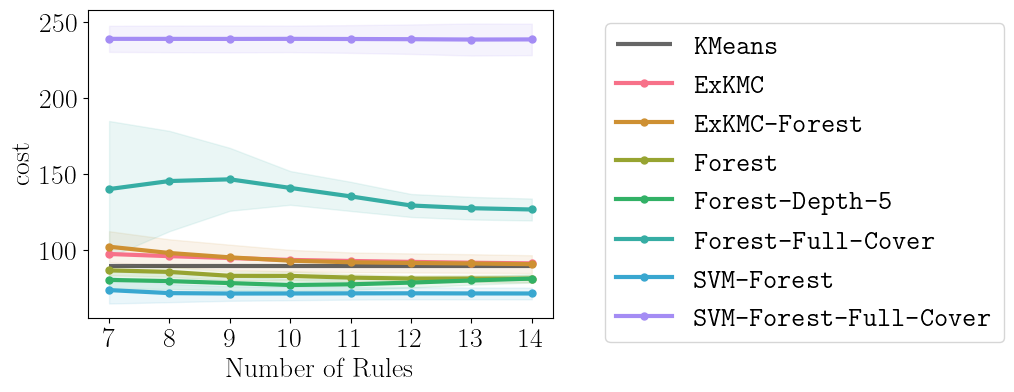

In [12]:
fname = None
#fname = '../figures/decision_sets/cost.png'
experiment_plotter(
    mean_df['point-average-clustering-cost'],
    std_df['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)
#plt.ylim(80,110)

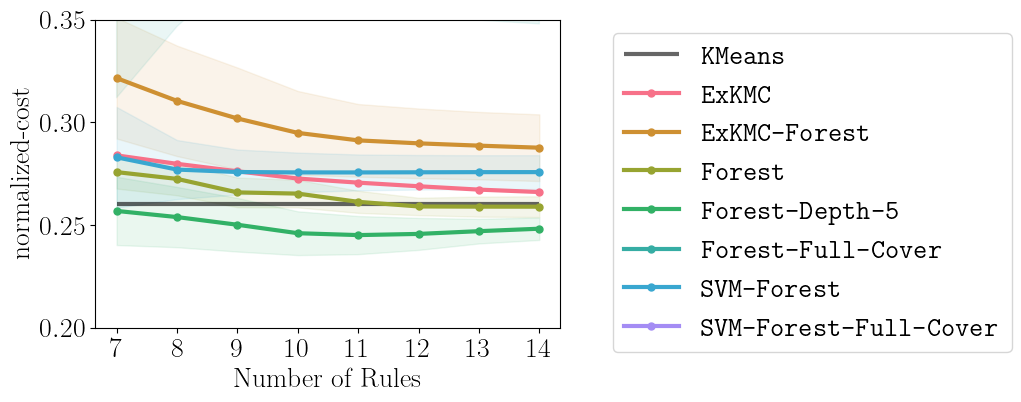

In [64]:
fname = None
fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'normalized-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)
plt.ylim(0.2,0.35)

### Covered Cost

In [53]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

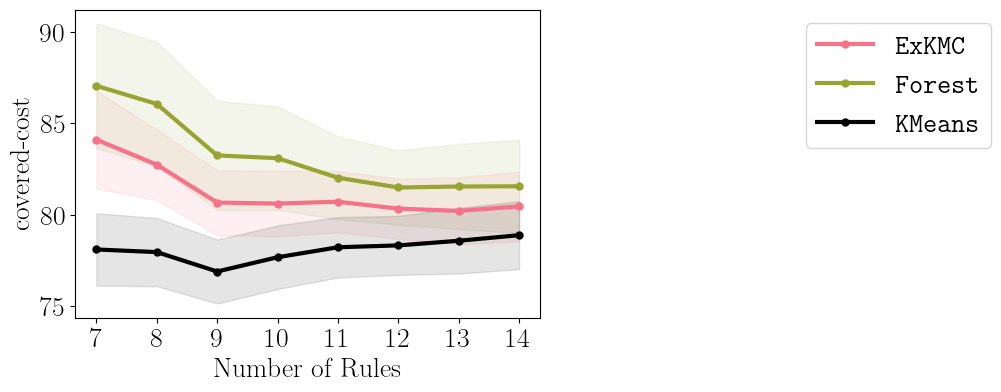

In [61]:
covered_cost_colors = [cmap(0), cmap(2), 'black']
covered_cost_colormap = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_covered_cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [59]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate_depth_5.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

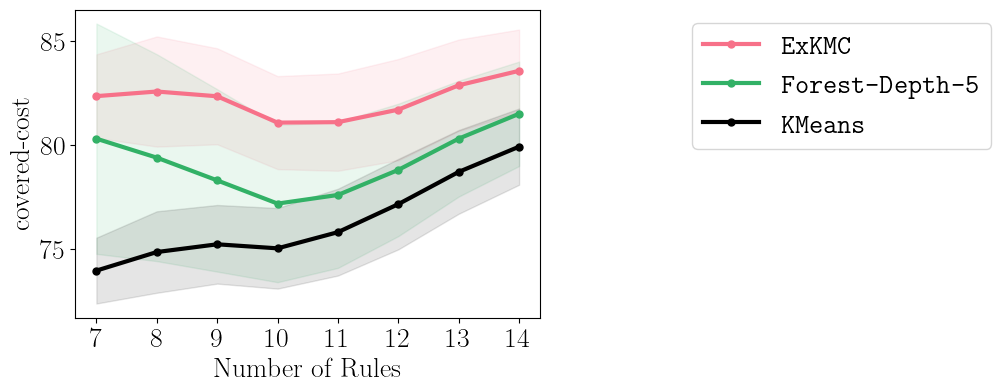

In [62]:
covered_cost_colors = [cmap(0), cmap(3), 'black']
covered_cost_colormap2 = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_d5_covered_cost.png'
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap2,
    legend = True,
    filename = fname,
    baseline_list = []
)